In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import argparse
import json
import os
import warnings
import sys
sys.path.append('../')
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np

from domains.synthetic_data_sampler import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import *
from main_functions import *
warnings.filterwarnings('ignore')

all_results = {}
all_results_train_size = {}
test_sizes = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
for test_size in test_sizes:
    all_results[test_size] = {}
    all_results_train_size[test_size] = []
    args = parse_arguments()
    args.test_size = test_size
    main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
    module_function_types = ["polyval"] * args.num_modules

    sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                    args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                    args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                    heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                    use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                    run_env=args.run_env)

    # first sample the data and prepare it
    data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path, test_size=test_size, test_on_last_depth=True)

    # Load train and test qids
    train_qids, test_qids = load_train_test_qids(csv_path, args)

    # Scale data
    if args.scale:
        create_module_scalers(csv_path, obs_data_path, scaler_path, train_qids, args.bias_strength)
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)

    # Load train and test data
    train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

    train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
    covariates = [x for x in train_df.columns if "feature" in x]


    # covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
    if args.systematic:
        covariates += [x for x in train_df.columns if "num" in x]

    print(f"Training data shape: {train_df.shape}")
    print("Covaariates: ", covariates)
    treatment, outcome = "treatment_id", "query_output"

    gt_effects_test = get_ground_truth_effects(data, test_qids)
    gt_effects_train = get_ground_truth_effects(data, train_qids) 

    model_effects_train = {}
    model_effects_test = {}

    input_dim = len(covariates)
    if input_dim < args.hidden_dim and args.covariates_shared:
        hidden_dim = args.hidden_dim 
    else:
        hidden_dim = (input_dim + 1)*2
    models = {
        "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
        "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
    }

    results = {}
    for model_name, model_class in models.items():
        print(f"Training {model_name} Model")
        if model_name == "Baseline":
            model = model_class(input_dim + 1, hidden_dim, args.output_dim)
        else:
            model = model_class(input_dim + 1, hidden_dim, args.output_dim, args.num_modules)
        
        estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
            model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
        )
        gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
        estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
        results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
        results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
        model_effects_train[model_name] = estimated_effects_train
        model_effects_test[model_name] = estimated_effects_test


    # Catenets
    print("Training Catenets Model")
    estimated_effects_train, estimated_effects_test = train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids)
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results["Catenets_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results["Catenets_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    # Add Catenets effects
    model_effects_train["Catenets"] = estimated_effects_train
    model_effects_test["Catenets"] = estimated_effects_test
        
    print("Training Additive Model")
    additive_combined_train_df, additive_combined_test_df, module_csvs_train, module_csvs_test, module_train_sizes = get_additive_model_effects(
        csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
        batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path, bias_strength=args.bias_strength
    )
    
    results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
    results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"])

    module_pehe_sum_train, module_cov_train = decompose_module_errors(module_csvs_train, args.num_modules)
    module_pehe_sum_test, module_cov_test = decompose_module_errors(module_csvs_test, args.num_modules)
    results["Module_PEHE_decomposition_test"] = module_pehe_sum_test, module_cov_test
    results["Module_PEHE_decomposition_train"] = module_pehe_sum_train, module_cov_train

    # Save results and CSVs
    results_path = f"{main_dir}/results/systematic_{args.systematic}/results_{args.data_dist}_{args.composition_type}_covariates_shared_{args.covariates_shared}_use_subset_features_{args.use_subset_features}_test_size_{test_size}"
    os.makedirs(results_path, exist_ok=True)
    with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
        json.dump(results, f)

    results_csv_folder = f"{results_path}/csvs_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}"
    os.makedirs(results_csv_folder, exist_ok=True)
    # Save combined_df_test and modulbe_csvs here
    additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
    for module_file, module_csv in module_csvs_test.items():
        module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

    # Create combined DataFrames
    combined_df_train = combine_model_effects(gt_effects_train, model_effects_train, additive_combined_train_df)
    combined_df_test = combine_model_effects(gt_effects_test, model_effects_test, additive_combined_test_df)

    # Save combined DataFrames
    combined_df_train.to_csv(f"{results_csv_folder}/combined_effects_train.csv", index=False)
    combined_df_test.to_csv(f"{results_csv_folder}/combined_effects_test.csv", index=False)



    print(results)
    print(f"Results saved at {results_path}")
    print(f"CSVs saved at {results_csv_folder}")
    print("Done!")
    all_results[test_size] = results
    all_results_train_size[test_size] = [train_df.shape[0], list(module_train_sizes.values())]

num_modules:  10
train depths:  [2]
test depths:  [10]
Created scalers for module 9
Created scalers for module 8
Created scalers for module 10
Created scalers for module 6
Created scalers for module 7
Created scalers for module 5
Created scalers for module 4
Created scalers for module 1
Created scalers for module 3
Created scalers for module 2
All scalers created and saved in /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/observational_data/fixed_structure_True_outcomes_parallel_systematic_True/feature_sum_10/ood/scalers


KeyboardInterrupt: 

In [7]:
module_function_types

['polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval',
 'polyval']

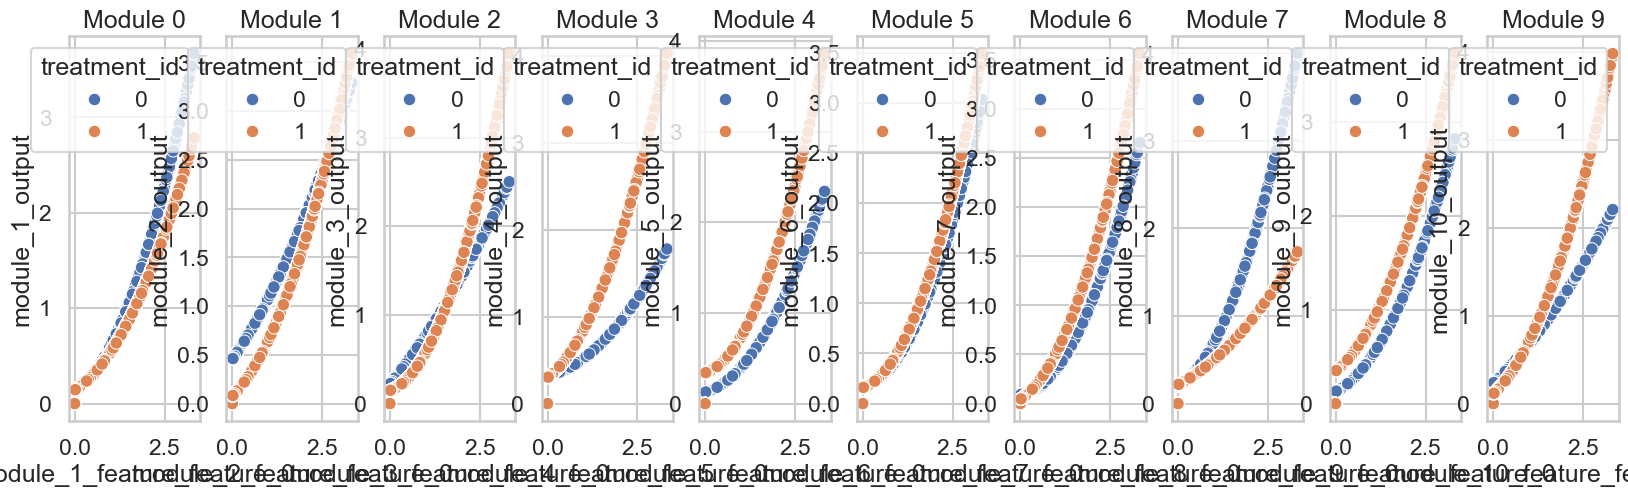

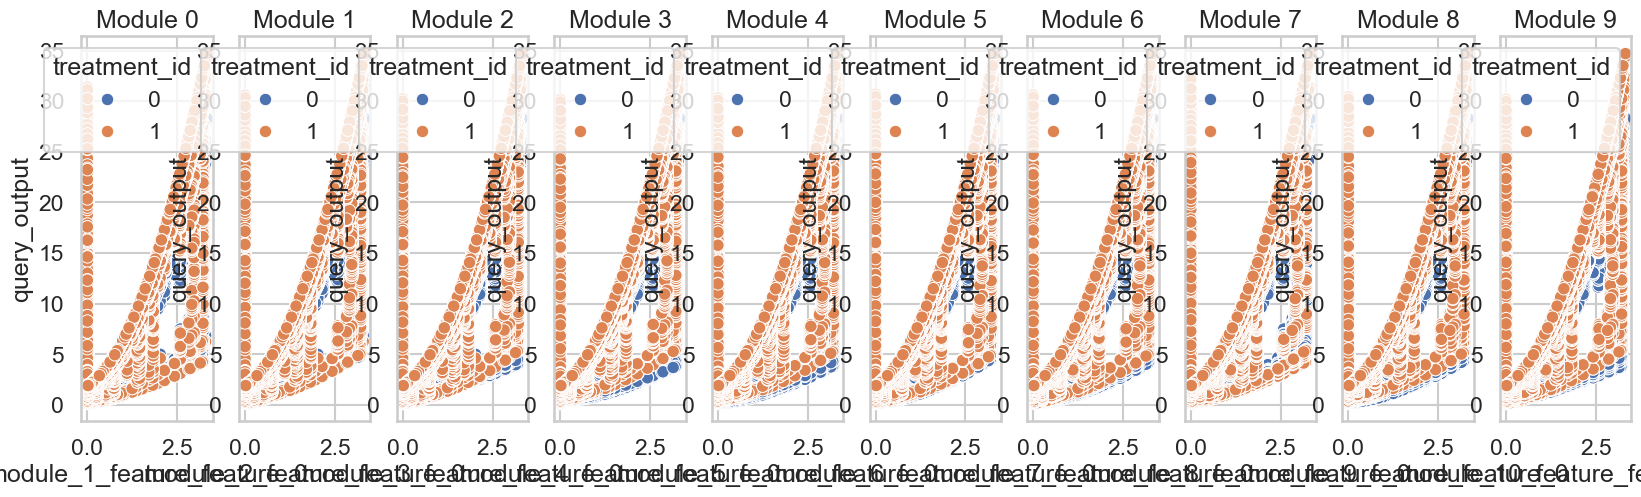

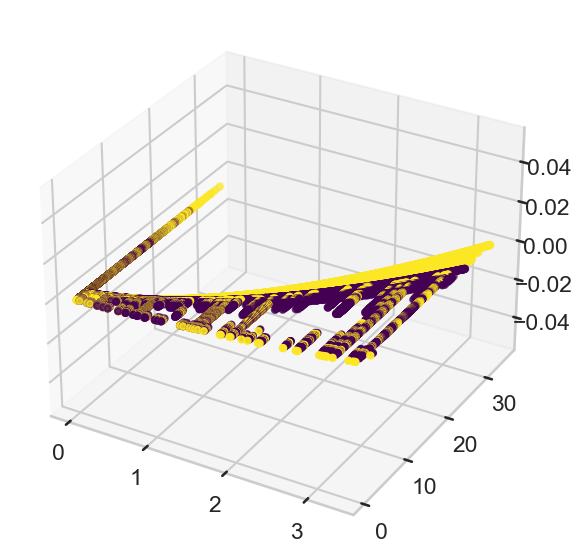

In [3]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = args.num_modules
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]


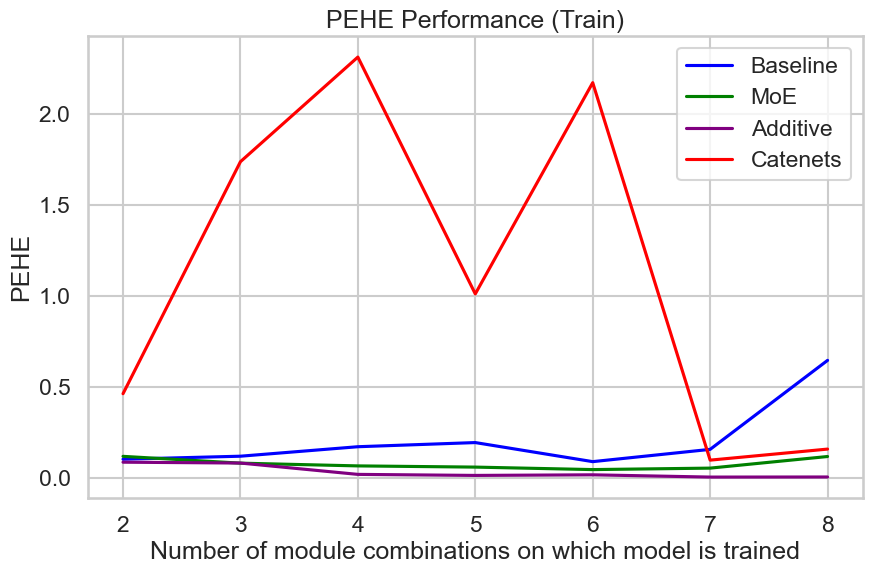

[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]


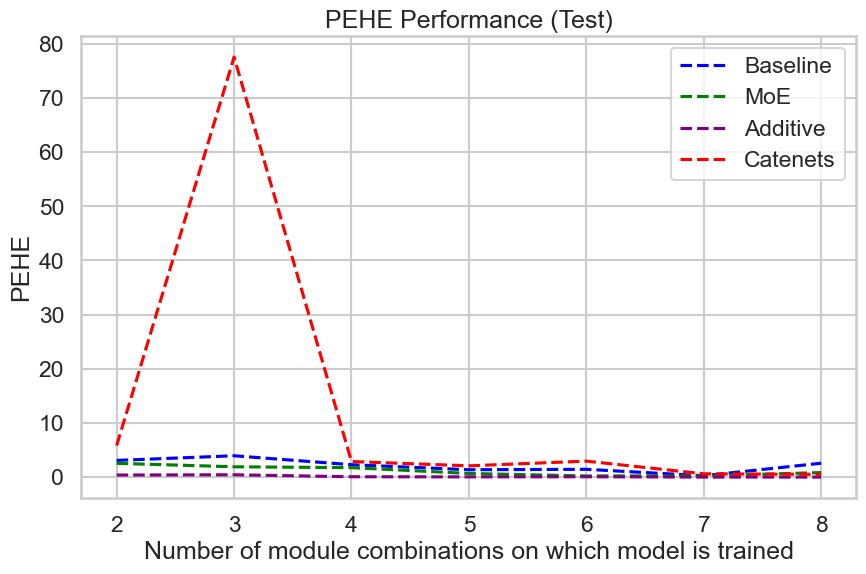

[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]


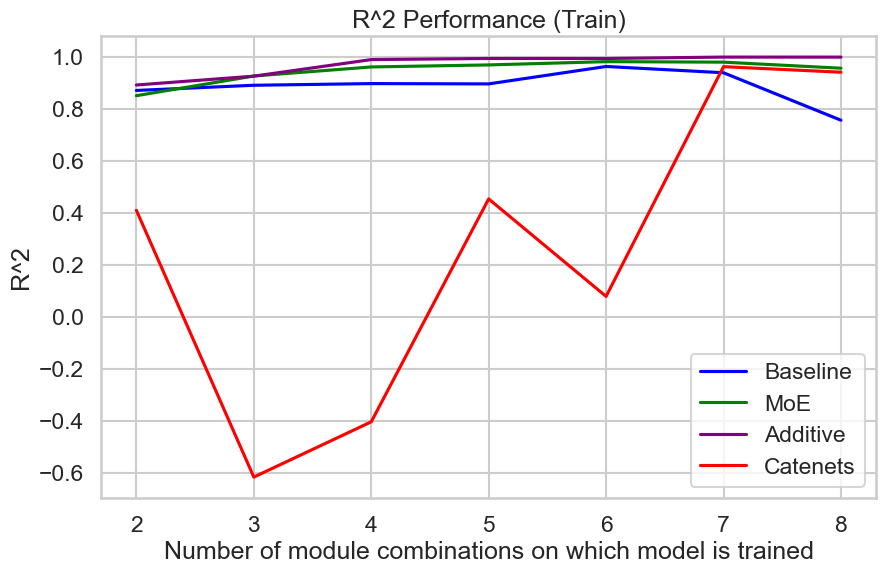

[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0]


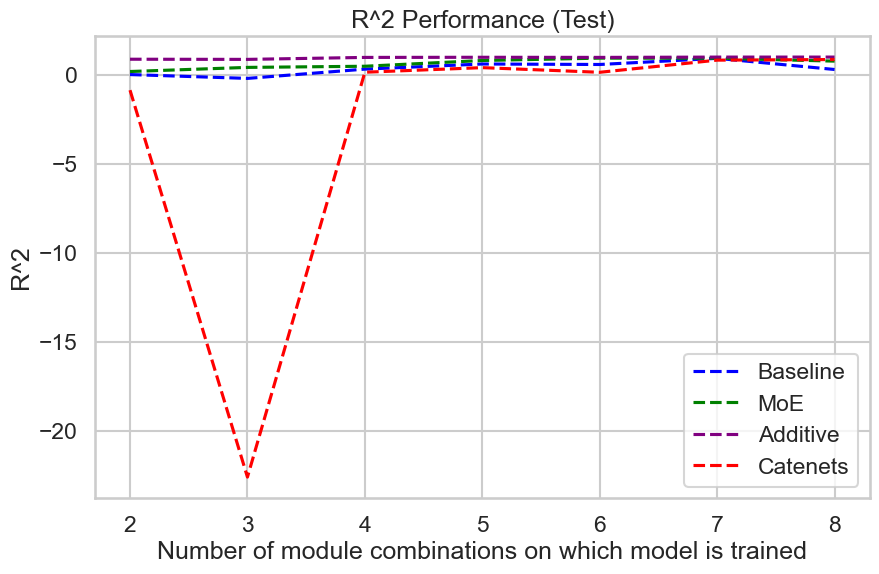

In [5]:
# Colors for each model
import math
colors = {
    'Baseline': 'blue',
    'MoE': 'green',
    'Catenets': 'red',
    'Additive': 'purple'
}

# Function to plot performance
def plot_performance(metric, metric_name, data_type):
    plt.figure(figsize=(10, 6))
    x = list(all_results.keys())
   
    
    for model in ['Baseline', 'MoE', 'Additive', 'Catenets']:
        y = [all_results[key][f'{model}_{data_type}'][metric] for key in x]
        x_plot = 1-np.array(x)
        print(x_plot)
        x_plot = [i*10 for i in x_plot]
        print(x_plot)
        plt.plot(x_plot, y, color=colors[model], label=model, 
                 linestyle='-' if data_type == 'train' else '--')
    
    plt.xlabel('Number of module combinations on which model is trained')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Performance ({data_type.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot PEHE for train and test
plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test')

# Plot R^2 for train and test
plot_performance(1, 'R^2', 'train')
plot_performance(1, 'R^2', 'test')

